In [70]:
import pandas as pd
import numpy as np
import math
from alibi_detect.cd import TabularDrift
from alibi_detect.cd import ClassifierDrift
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [8]:
df = pd.read_csv(r"D:/GitHubLocal/NHL-Game-II/Period_1_Game_Stats_Final_ModelReady(April-10th-2022).csv")

In [9]:
df.dtypes

won                        int64
Shots                    float64
Shots_Against            float64
Goals                    float64
Goals_Against            float64
Takeaways                float64
Takeaways_Against        float64
Hits                     float64
Hits_Against             float64
Blocked Shots            float64
Blocked Shots Against    float64
Giveaways                float64
Giveaways_Against        float64
Missed Shots             float64
Missed Shots_Against     float64
Penalities               float64
Penalities_Against       float64
#Won Faceoffs            float64
#Lost Faceoffs           float64
HoA_away                   int64
HoA_home                   int64
dtype: object

In [10]:
df.head()

,won,Shots,Shots_Against,Goals,Goals_Against,Takeaways,Takeaways_Against,Hits,Hits_Against,Blocked Shots,...,Giveaways,Giveaways_Against,Missed Shots,Missed Shots_Against,Penalities,Penalities_Against,#Won Faceoffs,#Lost Faceoffs,HoA_away,HoA_home
0,0,8.0,8.0,0.0,3.0,1.0,3.0,14.0,5.0,3.0,...,6.0,7.0,4.0,0.0,1.0,1.0,10.0,12.0,1,0
1,1,8.0,8.0,3.0,0.0,3.0,1.0,5.0,14.0,3.0,...,7.0,6.0,0.0,4.0,1.0,1.0,12.0,10.0,0,1
2,1,11.0,12.0,0.0,1.0,0.0,2.0,4.0,4.0,6.0,...,2.0,0.0,6.0,3.0,1.0,3.0,11.0,9.0,1,0
3,0,12.0,11.0,1.0,0.0,2.0,0.0,4.0,4.0,8.0,...,0.0,2.0,3.0,6.0,3.0,1.0,9.0,11.0,0,1
4,1,9.0,8.0,0.0,1.0,3.0,2.0,4.0,5.0,7.0,...,7.0,5.0,3.0,8.0,2.0,1.0,7.0,11.0,1,0


In [11]:
#Get the feature names
feature_names = df.columns

In [24]:
def split_ref_new(df, last_n):
    """
    Splits the main dataframe into a reference and new dataframe and np.array for drift detection
    """
    X_ref = np.array(df.iloc[:-last_n,:])
    df_ref = df.iloc[:-last_n,:]
    X_new = np.array(df.iloc[-last_n:,:])
    df_new = df.iloc[-last_n:,:]
    
    return X_ref, df_ref, X_new, df_new

In [25]:
X_ref, df_ref, X_new, df_new = split_ref_new(df, 30)

In [26]:
#TabularDrift: K-S tests for num features, Chi-squared for categorical
cd = TabularDrift(p_val=0.05, x_ref = X_ref)

In [27]:
#Predict general drift
preds = cd.predict(X_new, return_p_val=True, return_distance = True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!


In [28]:
#Predict the drift for each feature
fpreds = cd.predict(X_new, drift_type="feature", return_p_val=True, return_distance=True)

In [123]:
#Get drift per feature
feature_drift = []
for f in range(cd.n_features):
    stat = 'K-S'
    fname = feature_names[f]
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
    feature_drift.append(labels[is_drift])

won -- Drift? No! -- K-S 0.001 -- p-value 1.000
Shots -- Drift? No! -- K-S 0.205 -- p-value 0.141
Shots_Against -- Drift? No! -- K-S 0.105 -- p-value 0.863
Goals -- Drift? No! -- K-S 0.201 -- p-value 0.156
Goals_Against -- Drift? No! -- K-S 0.067 -- p-value 0.998
Takeaways -- Drift? No! -- K-S 0.145 -- p-value 0.506
Takeaways_Against -- Drift? No! -- K-S 0.079 -- p-value 0.985
Hits -- Drift? No! -- K-S 0.102 -- p-value 0.885
Hits_Against -- Drift? No! -- K-S 0.226 -- p-value 0.079
Blocked Shots -- Drift? No! -- K-S 0.154 -- p-value 0.433
Blocked Shots Against -- Drift? No! -- K-S 0.227 -- p-value 0.076
Giveaways -- Drift? No! -- K-S 0.081 -- p-value 0.981
Giveaways_Against -- Drift? No! -- K-S 0.087 -- p-value 0.962
Missed Shots -- Drift? No! -- K-S 0.086 -- p-value 0.967
Missed Shots_Against -- Drift? No! -- K-S 0.150 -- p-value 0.465
Penalities -- Drift? No! -- K-S 0.071 -- p-value 0.995
Penalities_Against -- Drift? No! -- K-S 0.091 -- p-value 0.945
#Won Faceoffs -- Drift? Yes! -- K-

In [129]:
def plot_features(new_data, ref_data):
    
    n_cols = 4
    n_rows = math.ceil((len(ref_data.columns)/4))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    axs = axs.ravel()
    
    for i in range(len(ref_data.columns)):
        ref_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="blue")
        new_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="red")
        
        axs[i].set_title(f'Distribution: {ref_data.columns[i]} - Drift: {feature_drift[i]}')
    
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

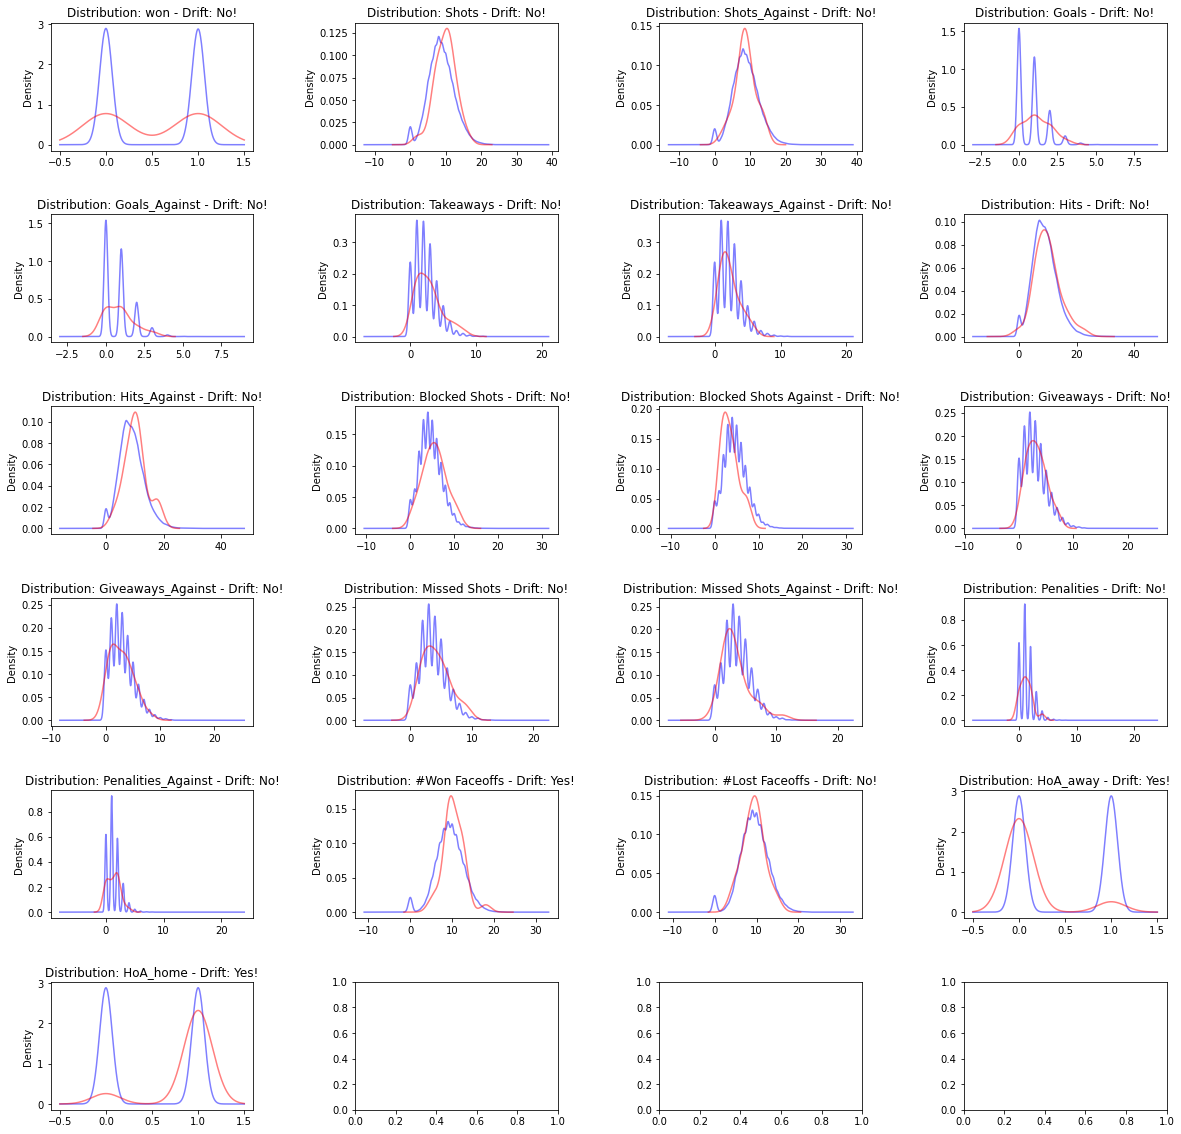

In [130]:
plot_features(df_new, df_ref)